In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
!pip install opencv-python-headless
!pip install albumentations==0.4.6
!pip install kornia
!pip install tensorboardX
!pip install numba
!pip install opencv-python; sudo apt-get update; sudo apt-get install ffmpeg libsm6 libxext6  -y;

  Using cached opencv_python_headless-4.6.0.66-cp36-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (48.3 MB)
  Using cached albumentations-0.4.6-py3-none-any.whl
  Using cached imgaug-0.4.0-py2.py3-none-any.whl (948 kB)
  Using cached Shapely-1.8.2-cp39-cp39-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (2.0 MB)
  Using cached imageio-2.19.3-py3-none-any.whl (3.4 MB)
  Using cached opencv_python-4.6.0.66-cp36-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (60.9 MB)
  Using cached scikit_image-0.19.3-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (14.0 MB)
  Using cached PyWavelets-1.3.0-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (6.9 MB)
  Using cached tifffile-2022.5.4-py3-none-any.whl (195 kB)
  Using cached networkx-2.8.4-py3-none-any.whl (2.0 MB)
  Using cached kornia-0.6.5-py2.py3-none-any.whl (512 kB)
  Using cached tensorboardX-2.5.1-py2.py3-none-any.whl (125 kB)
Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:2 

In [1]:
!rm -r /home/jovyan/workspace/model/*

### imports 

In [1]:
import os
import time
import torch
import datetime
import torchvision
import numpy as np
import matplotlib.cm
from math import exp
import torch.nn as nn
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch.optim as optim
from torchvision import models
import torch.nn.functional as F
from utils import WeatherDepthDataset
from torch.utils.data import DataLoader
from torchvision.utils import save_image
from utils import load_checkpoint, save_checkpoint, save_some_examples, colorize, ssim, DepthNorm, AverageMeter, LogProgress, evaluate_model, upscale_depth_img
torch.backends.cudnn.benchmark = True

from tensorboardX import SummaryWriter
from torch.autograd import Variable  

%matplotlib inline

### model

In [2]:
######################## ENCODER ########################

class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()       
        self.original_model = models.densenet169( pretrained=False )

    def forward(self, x):
        features = [x]
        for k, v in self.original_model.features._modules.items(): features.append( v(features[-1]) )
        return features
    

In [3]:
######################## DECODER ########################

class UpSample(nn.Sequential):
    def __init__(self, skip_input, output_features):
        super(UpSample, self).__init__()        
        self.convA = nn.Conv2d(skip_input, output_features, kernel_size=3, stride=1, padding=1)
        self.leakyreluA = nn.LeakyReLU(0.2)
        self.convB = nn.Conv2d(output_features, output_features, kernel_size=3, stride=1, padding=1)
        self.leakyreluB = nn.LeakyReLU(0.2)

    def forward(self, x, concat_with):
        up_x = F.interpolate(x, size=[concat_with.size(2), concat_with.size(3)], mode='bilinear', align_corners=True)
        return self.leakyreluB( self.convB( self.convA( torch.cat([up_x, concat_with], dim=1)  ) )  )

class Decoder(nn.Module):
    def __init__(self, num_features=1664, decoder_width = 1.0):
        super(Decoder, self).__init__()
        features = int(num_features * decoder_width)

        self.conv2 = nn.Conv2d(num_features, features, kernel_size=1, stride=1, padding=0)

        self.up1 = UpSample(skip_input=features//1 + 256, output_features=features//2)
        self.up2 = UpSample(skip_input=features//2 + 128,  output_features=features//4)
        self.up3 = UpSample(skip_input=features//4 + 64,  output_features=features//8)
        self.up4 = UpSample(skip_input=features//8 + 64,  output_features=features//16)

        self.conv3 = nn.Conv2d(features//16, 1, kernel_size=3, stride=1, padding=1)

    def forward(self, features):
        x_block0, x_block1, x_block2, x_block3, x_block4 = features[3], features[4], features[6], features[8], features[12]
        x_d0 = self.conv2(F.relu(x_block4))

        x_d1 = self.up1(x_d0, x_block3)
        x_d2 = self.up2(x_d1, x_block2)
        x_d3 = self.up3(x_d2, x_block1)
        x_d4 = self.up4(x_d3, x_block0)
        return self.conv3(x_d4)

In [4]:
######################## combined UNET ########################

class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x):
        return self.decoder( self.encoder(x) )
    
def test():
    x = torch.randn((1, 3, 512, 512))
    model = Model()
    preds = model(x)
    print(preds.shape)

test()

torch.Size([1, 1, 256, 256])


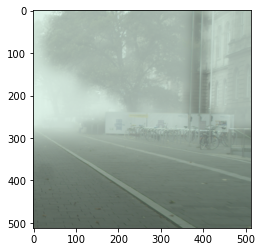

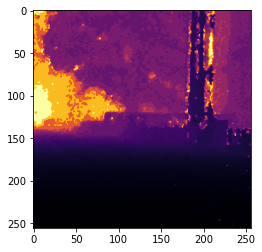

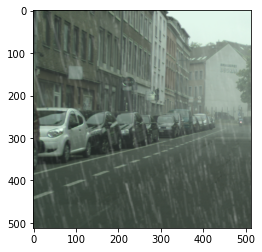

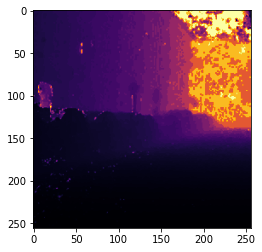

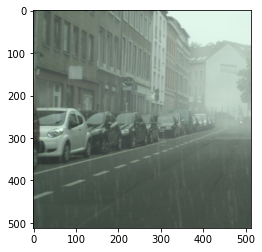

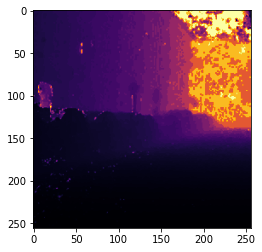

<Figure size 432x288 with 0 Axes>

In [5]:
dataset = WeatherDepthDataset(csv_file='val.csv',root_dir='data')
loader = DataLoader(dataset, batch_size=1)

# print(len(loader))
i = 0
for sample in loader:
  plt.imshow(torch.squeeze(sample['image']).permute(1, 2, 0))
  plt.figure()
  plt.imshow(torch.squeeze(DepthNorm(sample['depth'])), cmap='inferno')
  plt.figure()

  i += 1
  if (i > 2):
    break
    

### hyperparameters

In [6]:
ROOT_DIR = 'data'
TRAIN_CSV = 'train.csv'
TEST_CSV = 'val.csv'
LEARNING_RATE = 1e-4
BATCH_SIZE = 4
NUM_WORKERS = 2
IMAGE_SIZE = 256
CHANNELS_IMG = 3
L1_LAMBDA = 100
LAMBDA_GP = 10
NUM_EPOCHS = 20
STARTING_EPOCH = 0
LOAD_MODEL = False
SAVE_MODEL = True
CHECKPOINT_DISC = "checkpoints/disc.pth.tar"
CHECKPOINT_GEN = "checkpoints/gen.pth.tar"

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

### train

In [7]:
# Create model
model = Model().cuda()
print('Model created.')

# Training parameters
optimizer = torch.optim.Adam( model.parameters(), LEARNING_RATE )
prefix = 'densenet_' + str(BATCH_SIZE)

# Load data
train_dataset = WeatherDepthDataset(csv_file=TRAIN_CSV, root_dir=ROOT_DIR, is_train=True)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)

# Logging
writer = SummaryWriter(comment='{}-lr{}-e{}-bs{}'.format(prefix, LEARNING_RATE, NUM_EPOCHS, BATCH_SIZE), flush_secs=30)

# Loss
l1_criterion = nn.L1Loss()

if LOAD_MODEL:
    load_checkpoint('model/'+str(STARTING_EPOCH)+'.pth', model, optimizer, LEARNING_RATE)

# Start training...
for epoch in range(STARTING_EPOCH,NUM_EPOCHS):
    batch_time = AverageMeter()
    losses = AverageMeter()
    N = len(train_loader)

    # Switch to train mode
    model.train()

    end = time.time()

    for i, sample_batched in enumerate(train_loader):
        optimizer.zero_grad()

        # Prepare sample and target
        image = torch.autograd.Variable(sample_batched['image'].cuda())
        depth = torch.autograd.Variable(sample_batched['depth'].cuda(non_blocking=True))

        # Normalize depth
        depth_n = DepthNorm(depth)

        # Predict
        output = model(image)

        # Compute the loss
        l_depth = l1_criterion(output, depth_n)
        l_ssim = torch.clamp((1 - ssim(output, depth_n, val_range = 1000.0 / 10.0)) * 0.5, 0, 1)

        loss = (1.0 * l_ssim.mean().item()) + (0.1 * l_depth)

        # Update step
        losses.update(loss.data.item(), image.size(0))
        loss.backward()
        optimizer.step()

        # Measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()
        eta = str(datetime.timedelta(seconds=int(batch_time.val*(N - i))))
    
        # Log progress
        niter = epoch*N+i
        if i % 5 == 0:
            # Print to console
            print('Epoch: [{0}][{1}/{2}]\t'
            'Time {batch_time.val:.3f} ({batch_time.sum:.3f})\t'
            'ETA {eta}\t'
            'Loss {loss.val:.4f} ({loss.avg:.4f})'
            .format(epoch, i, N, batch_time=batch_time, loss=losses, eta=eta))

            # Log to tensorboard
            writer.add_scalar('Train/Loss', losses.val, niter)

        if i % 300 == 0:
            LogProgress(model, writer, test_loader, niter)

    # Record epoch's intermediate results
    LogProgress(model, writer, test_loader, niter)
    writer.add_scalar('Train/Loss.avg', losses.avg, epoch)

    # saves the updated model after each epoch
    path='model/'+str(epoch)+'.pth'        
    torch.save(model, path)   


Model created.


In [ ]:
model = Model().cuda()
model.load_state_dict(torch.load('/content/model/4.pth'))
model.eval()

### Save test examples

In [18]:
import cv2

# Save predicted depth maps to folder
for i,sample_batched1  in enumerate (test_loader):
    image1 = torch.autograd.Variable(sample_batched1['image'].cuda())
    
    pred_depth=model(image1) # predicted depth map tensor
    
    x=pred_depth.detach().cpu().numpy() # gets a numpy array from the tensor
    
    resized = upscale_depth_img()
    
    # save the rescale final depth map to disk
    plt.imsave('/content/results/%d_depth.jpg' %i, resized, cmap='inferno') 
    
    s_img=sample_batched1['image'].detach().cpu().numpy().reshape(3,512,512).transpose(1,2,0)
    plt.imsave('/content/results/%d_image.jpg' %i, s_img) 

    gt_resized = torch.squeeze(sample_batched1['depth'])
    gt_resized = DepthNorm(gt_resized)
    plt.imsave('/content/results/%d_depth_gt.jpg' %i, gt_resized, cmap='inferno') 


### Evaluation

In [ ]:
def load_checkpoint_state(checkpoint_file, model):
    print('=> Loading checkpoint state')
    checkpoint = torch.load(checkpoint_file, map_location=DEVICE)
    model.load_state_dict(checkpoint)

test_dataset = WeatherDepthDataset(csv_file=TEST_CSV, root_dir=ROOT_DIR)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

model = Model().to(DEVICE)
load_checkpoint_state('/home/jovyan/workspace/checkpoints/model/4.pth', model)
model.eval()

evaluate_model(model, test_loader)